In [1]:
import pandas as pd
import numpy as np
import os
import json
import joblib

import altair as alt
import vegafusion as vf

pd.options.mode.copy_on_write = True
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [2]:
# Pre-define chart function
def chart(df, x, y, title, color=alt.value('steelblue'), width=480, height=320):
    return alt.Chart(df).encode(
        x=x,
        y=y,
        color=color,
    ).properties(
    title=title,
    width=width,
    height=height,
).configure(
    axis=alt.AxisConfig(
        domain=False, # remove axis line
        ticks=False, # remove ticks
        labelAngle=0, # rotate labels
        labelColor='gray', # color of labels
        labelFontSize=10,
    ),
    font='Helvetica Neue',
    view=alt.ViewConfig(stroke=None), # remove border
)

## 1 - Load the training data

In [3]:
input_path = os.path.join('..', 'data', 'cleaned')

train_df = pd.read_parquet(os.path.join(input_path, 'train.parquet'))
train_df.head()

,file,VMONTH,VYEAR,VDAYR,AGE,AGER,SEX,ETHNIC,RACE,USETOBAC,...,PHYS,PHYSASST,NPNMW,RNLPN,OTHPROV,MHP,REFOTHMD,RETAPPT,OTHDISP,ERADMHOS
0,opd2006,12,2006,6,55,4,2,2,1,1,...,1,0,0,0,0,<NA>,0,0,0,0
1,opd2006,11,2006,5,66,5,2,2,1,1,...,1,0,0,0,0,<NA>,0,0,0,0
2,opd2006,11,2006,4,71,5,1,2,1,1,...,1,0,0,0,0,<NA>,1,0,0,0
3,opd2006,11,2006,3,1,1,1,2,1,1,...,1,0,0,0,0,<NA>,0,0,0,0
4,opd2006,11,2006,2,21,2,1,2,1,2,...,1,0,0,0,0,<NA>,0,0,0,0


## 2 - Load the vairiables dictionary and define features for clustering

In [4]:
# Load the variables dictionary
with open(os.path.join(input_path, 'variables.json'), 'r') as f:
    variables = json.load(f)

print(f'Variable Categories:\n')
for category, list in variables.items():
    print(f'{category}')
    print(f'{list}')

Variable Categories:

dateOfVisit
['VMONTH', 'VYEAR', 'VDAYR']
demographics
['AGE', 'AGER', 'SEX', 'ETHNIC', 'RACE', 'USETOBAC']
payment
['PAYPRIV', 'PAYMCARE', 'PAYMCAID', 'PAYWKCMP', 'PAYSELF', 'PAYNOCHG', 'PAYOTH', 'PAYDK', 'PAYTYPER']
visitReason
['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
patientClinicHistory
['SENBEFOR', 'PASTVIS']
vitalSigns
['HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
imputedFields
['BDATEFL', 'SEXFL', 'SENBEFL', 'PASTFL']
physicianDiagnoses
['DIAG1', 'DIAG2', 'DIAG3']
differentialDiagnoses
['PRDIAG1', 'PRDIAG2', 'PRDIAG3']
presentSymptomsStatus
['ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS']
services
['BREAST', 'PELVIC', 'RECTAL', 'SKIN', 'DEPRESS', 'BONEDENS', 'MAMMO', 'MRI', 'ULTRASND', 'XRAY', 'OTHIMAGE', 'CBC', 'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA', 'OTHERBLD', 'BIOPSY', 'CHLAMYD', 'PAPCONV', 'PAPLIQ', 'PAPUNSP', 'HPVDNA', 'EKG', 'URINE', 'HTTAKE', 'WTTAKE

### 2.1 Defining features

##### !!! The statistical test result of the features should be referred first

In [5]:
train_df[variables['visitReason']].value_counts()

INJDET  MAJOR  RFV1   RFV2   RFV3 
5       2      48000  44100  41150    40
1       2      23200  48000  44100    25
5       1      10100  14400  14000    21
               14400  14000  14551    21
1       3      46050  47350  11500    20
                                      ..
5       1      14400  15950  15300     1
                             14750     1
                             10200     1
                      15702  41150     1
        5      89980  45650  42050     1
Name: count, Length: 7796, dtype: int64

In [6]:
# Defining the independent variables as features for classification
features = \
    ['AGE', 'SEX', 'USETOBAC'] + variables['visitReason'] + ['PASTVIS'] + variables['vitalSigns'] \
    + variables['presentSymptomsStatus']

print(f'Features: {features}')
print(f'Number of Features: {len(features)}')

Features: ['AGE', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS']
Number of Features: 30


In [7]:
X_train = train_df.loc[:, features].copy()

## 3 - Preprocess and engineer the features

 ### 3.1 - Bin the Reason for Visit variables into Modules
 RFV1, RFV2, RFV3

In [8]:
# Load the REASON FOR VISIT classification summary of codes
rvf_summary = pd.read_excel(os.path.join('..', 'data', 'raw', 'RFV_codes_summary.xlsx'))

# Split the 'CODE NUMBER' column into 'START' and 'END' columns
rvf_summary[['START', 'END']] = rvf_summary['CODE NUMBER'].str.split('-', expand=True).astype(int)

rvf_summary.sample(5)

,MODULE_1,MODULE_2,CODE NUMBER,START,END
25,DISEASE MODULE,Perinatal Morbidity and Mortality Conditions,2980-2999,2980,2999
26,"DIAGNOSTIC, SCREENING AND PREVENTIVE MODULE",General Examinations,3100-3199,3100,3199
7,SYMPTOM MODULE,Symptoms Referable to the Genitourinary System,1640-1829,1640,1829
14,DISEASE MODULE,Mental Disorders,2300-2349,2300,2349
2,SYMPTOM MODULE,Symptoms Referable to the Nervous System (Excl...,1200-1259,1200,1259


In [9]:
# Find the `START` and `END` range, 
# and map the corresponding `MODULE_2` to X_train,
# according to the value of `RFV1`

def get_module(code):
    return rvf_summary[(rvf_summary['START'] <= code) & (rvf_summary['END'] >= code)]['MODULE_2'].values[0]


X_train['RFV1_MOD'] = X_train['RFV1'].apply(lambda x: get_module(int(str(x)[:4])).strip() if pd.notna(x) else pd.NA)
print(f'RFV1 unique values: {X_train["RFV1_MOD"].value_counts()}')

X_train['RFV2_MOD'] = X_train['RFV2'].apply(lambda x: get_module(int(str(x)[:4])).strip() if pd.notna(x) else pd.NA)
print(f'RFV2 unique values: {X_train["RFV2_MOD"].value_counts()}')

X_train['RFV3_MOD'] = X_train['RFV3'].apply(lambda x: get_module(int(str(x)[:4])).strip() if pd.notna(x) else pd.NA)
print(f'RFV3 unique values: {X_train["RFV3_MOD"].value_counts()}')

RFV1 unique values: RFV1_MOD
Progress Visit, NEC                                                  9641
Symptoms Referable to the Musculoskeletal System                     8232
Special Examinations                                                 7416
General Examinations                                                 6895
Symptoms Referable to the Respiratory System                         5908
General Symptoms                                                     4536
Injury by Type and/or Location                                       4312
Symptoms Referable to Psychological and Mental Disorders             4048
Symptoms Referable to the Genitourinary System                       3847
Diagnostic Tests                                                     3801
Symptoms Referable to the Digestive System                           3301
Preoperative and Postoperative Care                                  2971
Symptoms Referable to the Skin, Nails, and Hair                      2845
Symptoms 

### 3.2 - Binning of quantitative variables to categorical features
Bin the following quantitative variables:

AGE, BMI, TEMPF, BPSYS, BPDIAS

#### 3.2.1 - Bin the AGE variable
Do we bin as recoded age groups (`AGER`) or as each 20 years?

In [10]:
# Check the distribution of `AGER`
# 1 = Under 15 years 
# 2 = 15-24 years 
# 3 = 25-44 years 
# 4 = 45-64 years 
# 5 = 65-74 years 
# 6 = 75 years and over|
 
chart(
    df=train_df,
    x='AGER:O',
    y='count()',
    title='Distribution of AGER',
).mark_bar().interactive()

alt.Chart(...)

In [11]:
# Bin the AGE variable as age groups
# 0-2 = Infant
# 2-4 = Toddler
# 4-12 = Child
# 12-20 = Teenager
# 20-40 = Adult
# 40-60 = Middle Aged
# >= 60 = Senior

age_groups = ['Infant', 'Toddler', 'Child', 'Teenager', 'Child or Teenager', 'Adult', 'Middle Aged', 'Senior']

def bin_age(age):
    if pd.isna(age): return pd.NA
    #if age < 2: return 'Infant'
    #elif age < 4: return 'Toddler'
    #elif age < 12: return 'Child'
    #elif age < 20: return 'Teenager'
    elif age < 20: return 'Child or Teenager'
    elif age < 40: return 'Adult'
    elif age < 60: return 'Middle Aged'
    else: return 'Senior'
    

X_train['AGE_GROUP'] = X_train['AGE'].apply(bin_age)

# Check the distribution of age groups
chart(
    df=X_train,
    x=alt.X('AGE_GROUP:O', sort=age_groups),
    y='count()',
    title='Distribution of AGE GROUPS',
).mark_bar().interactive()

alt.Chart(...)

#### 3.2.2 - Bin the vitalSigns variables
BMI, TEMPF, BPSYS, BPDIAS

In [12]:
# Bin the BMI as weight status
# <18.5 = Underweight
# 18.5-25 = Normal weight
# 25-30 = Overweight
# >=30 = Obesity

bmi_groups = ['Underweight', 'Normal weight', 'Overweight', 'Obesity']

def bin_bmi(bmi):
    if pd.isna(bmi): return pd.NA
    elif bmi < 18.5: return 'Underweight'
    elif bmi < 25: return 'Normal weight'
    elif bmi < 30: return 'Overweight'
    else: return 'Obesity'

X_train['BMI_GROUP'] = X_train['BMI'].apply(bin_bmi)

# Check the distribution of BMI groups
chart(
    df=X_train,
    x=alt.X('BMI_GROUP:O', sort=bmi_groups),
    y='count()',
    title='Distribution of BMI GROUPS',
).mark_bar().interactive()

alt.Chart(...)

In [13]:
# Bin the TEMPF as fever status
# <95 = Hypothermia
# 95-99 = Normal temperature
# 99-100 = Low grade fever
# 100-103 = Fever
# >=103 = Hyperpyrexia

tempf_groups = ['Hypothermia', 'Normal temperature', 'Low grade fever', 'Fever', 'Hyperpyrexia']

def bin_tempf(tempf):
    if pd.isna(tempf): return pd.NA
    elif tempf < 95: return 'Hypothermia'
    elif tempf < 99: return 'Normal temperature'
    #elif tempf < 100: return 'Low grade fever'
    elif tempf < 103: return 'Fever'
    else: return 'Hyperpyrexia'

X_train['TEMPF_GROUP'] = X_train['TEMPF'].apply(bin_tempf)

# Check the distribution of TEMPF groups
chart(
    df=X_train,
    x=alt.X('TEMPF_GROUP:O', sort=tempf_groups),
    y='count()',
    title='Distribution of TEMPF GROUPS',
).mark_bar().interactive()

alt.Chart(...)

In [14]:
# Bin the BPSYS as systolic blood pressure status
# <90 = Hypotension
# 90-120 = Normal blood pressure
# 120-140 = Prehypertension
# >=140 = Hypertension

bpsys_groups = ['Hypotension', 'Normal blood pressure', 'Prehypertension', 'Hypertension']

def bin_bpsys(bpsys):
    if pd.isna(bpsys): return pd.NA
    elif bpsys < 90: return 'Hypotension'
    elif bpsys < 120: return 'Normal blood pressure'
    elif bpsys < 140: return 'Prehypertension'
    else: return 'Hypertension'

X_train['BPSYS_GROUP'] = X_train['BPSYS'].apply(bin_bpsys)

# Check the distribution of BPSYS groups
chart(
    df=X_train,
    x=alt.X('BPSYS_GROUP:O', sort=bpsys_groups),
    y='count()',
    title='Distribution of BPSYS GROUPS',
).mark_bar().interactive()

alt.Chart(...)

In [15]:
# Bin the BPDIAS as diastolic blood pressure status
# <60 = Low diastolic blood pressure
# 60-90 = Normal diastolic blood pressure
# 90-110 = High diastolic blood pressure
# >=110 = Hypertension

bpdias_groups = [
    'Low diastolic blood pressure', 'Normal diastolic blood pressure', 'High diastolic blood pressure', 'Hypertension'
]

def bin_bpdias(bpdias):
    if pd.isna(bpdias): return pd.NA
    elif bpdias < 60: return 'Low diastolic blood pressure'
    elif bpdias < 90: return 'Normal diastolic blood pressure'
    elif bpdias < 110: return 'High diastolic blood pressure'
    else: return 'Hypertension'

X_train['BPDIAS_GROUP'] = X_train['BPDIAS'].apply(bin_bpdias)

# Check the distribution of BPDIAS groups
chart(
    df=X_train,
    x=alt.X('BPDIAS_GROUP:O', sort=bpdias_groups),
    y='count()',
    title='Distribution of BPDIAS GROUPS',
).mark_bar().interactive()

alt.Chart(...)

### 3.3 - Create interaction features
AGE, HTIN, WTLB, BMI, BPSYS, BPDIAS, CEBVD, CHF, DIABETES, HYPLIPID, HTN, OBESITY

### 3.4 - Dimensionality reduction for categorical features

### 3.5 - Redefine the features for training

In [16]:
binary_features = [feature for feature in features if X_train[feature].nunique() == 2]
print(f'Binary Features: {binary_features}')

ordinal_features = ['CASTAGE']
print(f'Ordinal Features: {ordinal_features}')
print()

# With Binned Groups
quantitative_features_w_bin = ['PASTVIS', 'HTIN', 'WTLB']
print(f'Quantitative Features with Binned Groups: {quantitative_features_w_bin}')

nominal_features_w_bin = ['INJDET', 'MAJOR'] + ['RFV1_MOD', 'RFV2_MOD', 'RFV3_MOD'] + ['AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
print(f'Nominal Features with Binned Groups: {nominal_features_w_bin}')

print(f'Number of Features with Binned Groups: {len(quantitative_features_w_bin + binary_features + ordinal_features + nominal_features_w_bin)}')
print()

# Without Binned Groups
quantitative_features_wo_bin = ['AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
print(f'Quantitative Features without Binned Groups: {quantitative_features_wo_bin}')
nominal_features_wo_bin = ['INJDET', 'MAJOR'] + ['RFV1', 'RFV2', 'RFV3']
print(f'Nominal Features without Binned Groups: {nominal_features_wo_bin}')

print(f'Number of Features without Binned Groups: {len(quantitative_features_wo_bin + binary_features + ordinal_features + nominal_features_wo_bin)}')


Binary Features: ['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS']
Ordinal Features: ['CASTAGE']

Quantitative Features with Binned Groups: ['PASTVIS', 'HTIN', 'WTLB']
Nominal Features with Binned Groups: ['INJDET', 'MAJOR', 'RFV1_MOD', 'RFV2_MOD', 'RFV3_MOD', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
Number of Features with Binned Groups: 30

Quantitative Features without Binned Groups: ['AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
Nominal Features without Binned Groups: ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
Number of Features without Binned Groups: 30


### 3.6 - Handeling missing values in categorical features

In [17]:
# Check the missing values in X_train
print(f'Missing Values in X_train: \n{X_train.isna().sum().where(lambda x: x > 0).dropna()}')
print()

# Fill the missing values in the categorical features
# with -9 for 'CASTAGE',
# with -999 for 'USETOBAC', 'INJDET', 'MAJOR',
# with '-9' for 'RFV1', 'RFV2', 'RFV3'
# with 'NA' for 'RFV1_MOD', 'RFV2_MOD', 'RFV3_MOD', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP'
X_train.fillna({'CASTAGE': -9}, inplace=True)
X_train.fillna({'USETOBAC': -999, 'INJDET': -999, 'MAJOR': -999}, inplace=True)
X_train.fillna({'RFV1': '-9', 'RFV2': '-9', 'RFV3': '-9'}, inplace=True)
X_train.fillna(
    {'RFV1_MOD': 'NA', 'RFV2_MOD': 'NA', 'RFV3_MOD': 'NA', 'BMI_GROUP': 'NA', 'TEMPF_GROUP': 'NA', 'BPSYS_GROUP': 'NA', 'BPDIAS_GROUP': 'NA'},
    inplace=True
)


# Check the missing values in X_train after filling
print(f'Missing Values in X_train after Filling: \n{X_train.isna().sum().where(lambda x: x > 0).dropna()}')

Missing Values in X_train: 
USETOBAC         40100.0
INJDET           32459.0
MAJOR             2103.0
RFV1              1268.0
RFV2             67179.0
RFV3             90754.0
PASTVIS          19878.0
HTIN             56172.0
WTLB             34554.0
BMI              65377.0
TEMPF            57028.0
BPSYS            40808.0
BPDIAS           40923.0
CASTAGE         100260.0
RFV1_MOD          1268.0
RFV2_MOD         67179.0
RFV3_MOD         90754.0
BMI_GROUP        65377.0
TEMPF_GROUP      57028.0
BPSYS_GROUP      40808.0
BPDIAS_GROUP     40923.0
dtype: float64

Missing Values in X_train after Filling: 
PASTVIS    19878.0
HTIN       56172.0
WTLB       34554.0
BMI        65377.0
TEMPF      57028.0
BPSYS      40808.0
BPDIAS     40923.0
dtype: float64


## 4 - Prepare dependent variables

In [18]:
# Check the missing values in 'DIAG1', 'DIAG2', and 'DIAG3'
print(f'Missing Values in DIAG1: {train_df["DIAG1"].isna().sum()}')
print(f'Missing Values in DIAG2: {train_df["DIAG2"].isna().sum()}')
print(f'Missing Values in DIAG3: {train_df["DIAG3"].isna().sum()}')
print()

# Check the numbers of ruled out or questionable diagnoses
# (when 'PRDIAG1', 'PRDIAG2', and 'PRDIAG3' equals to 1)
print(f'Number of Ruled Out Diagnoses in DIAG1: {train_df["PRDIAG1"].sum()}')
print(f'Number of Ruled Out Diagnoses in DIAG2: {train_df["PRDIAG2"].sum()}')
print(f'Number of Ruled Out Diagnoses in DIAG3: {train_df["PRDIAG3"].sum()}')
print()

# Check the number of samples with missing 'DIAG1' and 'PRDIAG1' equals to 1
print(f'Number of Samples with Missing DIAG1 and PRDIAG1 equals to 1: {train_df[(train_df["DIAG1"].isna()) & (train_df["PRDIAG1"] == 1)].shape[0]}')
print()

# Check the number of available dependent samples
# (when 'DIAG1' is not missing and 'PRDIAG1' is not 1)
print(f'Number of Available Dependent Samples: {train_df[(~train_df["DIAG1"].isna()) & (train_df["PRDIAG1"] != 1)].shape[0]}')

Missing Values in DIAG1: 1214
Missing Values in DIAG2: 53134
Missing Values in DIAG3: 79860

Number of Ruled Out Diagnoses in DIAG1: 940
Number of Ruled Out Diagnoses in DIAG2: 1054
Number of Ruled Out Diagnoses in DIAG3: 493

Number of Samples with Missing DIAG1 and PRDIAG1 equals to 1: 5

Number of Available Dependent Samples: 101337


### 4.1 - Load and the list of three-digit categories of ICD-9-CM

In [19]:
# Load the list of three-digit categories of ICD-9-CM
icd9cm_3dcat = pd.read_excel(os.path.join('..', 'data', 'raw', 'ICD9CM_3DCat.xlsx'), dtype=str)

icd9cm_3dcat.head()

,3D_CODE,DISEASE,CATEGORY_1,CATEGORY_2
0,001,Cholera,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
1,002,Typhoid and paratyphoid fevers,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
2,003,Other salmonella infections,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
3,004,Shigellosis,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
4,005,Other food poisoning (bacterial),INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases


### 4.2 - Employing the hierachical classifications of ICD-9-CM codes to prepare the target labels

In [20]:
# Map the three-digit categories of ICD-9-CM to 'DIAG1', 'DIAG2', and 'DIAG3',
# if 'PRDIAG1', 'PRDIAG2', and 'PRDIAG3' are not 1 respectively

def get_icd9cm_3dcat(diag, prdiag, category='CATEGORY_1'):
    try:
        if pd.notna(diag) and (pd.isna(prdiag) | prdiag != 1):
            if diag == 'V997-':
                return 'No diagnosis/disease or healthy'
            else:
                return icd9cm_3dcat[icd9cm_3dcat['3D_CODE'] == diag[:3]][category].values[0]
        else:
            return pd.NA
    except:
        print(f'Error: {diag}')
        print(f'Error: {prdiag}')

    
get_icd9cm_3dcat(train_df.iloc[0].DIAG1, train_df.iloc[0].PRDIAG1, category='CATEGORY_2')

'Certain traumatic complications and unspecified injuries'

In [21]:
# Map the three-digit categories of ICD-9-CM to 'DIAG1', 'DIAG2', and 'DIAG3',
# if 'PRDIAG1', 'PRDIAG2', and 'PRDIAG3' are not 1 respectively

y_train = train_df.apply(lambda x: get_icd9cm_3dcat(x.DIAG1, x.PRDIAG1, category='CATEGORY_1'), axis=1)
y_train_cat2 = train_df.apply(lambda x: get_icd9cm_3dcat(x.DIAG1, x.PRDIAG1, category='CATEGORY_2'), axis=1)

print(f'Dependent DataFrame with CATEGORY_1 Shape: {y_train.shape}')
print(f'Dependent DataFrame with CATEGORY_2 Shape: {y_train_cat2.shape}')

Dependent DataFrame with CATEGORY_1 Shape: (103486,)
Dependent DataFrame with CATEGORY_2 Shape: (103486,)


### 4.3 - Drop the rows from both X_train, y_train with NA in y_train

In [22]:
print(f'Number of available dependent samples: {y_train.notna().sum()}')
print()

non_missing_mask = y_train.notna()

X_train = X_train.loc[non_missing_mask]

y_train = y_train.loc[non_missing_mask]
y_train_cat2 = y_train_cat2[non_missing_mask]

print(f'X_train Shape: {X_train.shape}')
print(f'y_train with CATEGORY_1 Shape: {y_train.shape}')
print(f'y_train with CATEGORY_2 Shape: {y_train_cat2.shape}')

Number of available dependent samples: 101337

X_train Shape: (101337, 38)
y_train with CATEGORY_1 Shape: (101337,)
y_train with CATEGORY_2 Shape: (101337,)


## 5 - Classification models

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

random_state = 42

### 5.1 - Model training

#### 5.1.1 - Logistic Regression - Baseline model

##### 5.1.1.1 - Logistic Regression - Dropping the quantitative columns with missing values

In [51]:
# Setup the pipeline
def set_pipeline(model, binary_features, ordinal_features, nominal_features, quantitative_features, imputer=None, n_neighbors=5):
    # Define the column transformer for the independent variables
    preprocessor = ColumnTransformer(
        transformers=[
            ('binary', 'passthrough', binary_features),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), nominal_features),
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-9), ordinal_features),
        ]
    )

    if imputer == 'knn':
        preprocessor.transformers.insert(1, ('impute', KNNImputer(n_neighbors=n_neighbors), quantitative_features))

    # Define the pipeline
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler()),
            ('classifier', model),
        ]
    )

    #if imputer == 'knn':
    #    pipeline.steps.insert(2, ('imputer', KNNImputer(n_neighbors=n_neighbors)))

    return pipeline

In [47]:
quantitative_features = quantitative_features_w_bin
nominal_features = nominal_features_w_bin

features = binary_features + ordinal_features + nominal_features + quantitative_features

# Drop the quantitative columns with missing values
print(f'Dropping columns with missing values: {set(X_train[features].columns) - set(X_train[features].dropna(axis=1).columns)}')
quantitative_features = [feature for feature in quantitative_features if feature in X_train[features].dropna(axis=1).columns]

print(f'Shape of X_train after dropping columns with missing values: {X_train[features].dropna(axis=1).shape}')
print(f'Features after dropping columns with missing values: \n{X_train[features].columns}')
print()

# Define the model
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Dropping columns with missing values: {'HTIN', 'PASTVIS', 'WTLB'}
Shape of X_train after dropping columns with missing values: (101337, 27)
Features after dropping columns with missing values: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1_MOD', 'RFV2_MOD',
       'RFV3_MOD', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP',
       'BPDIAS_GROUP', 'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')

Cross-Validation Scores: [0.5024088  0.50871329 0.49835975 0.51166551 0.49907291]
Mean Cross-Validation Score: 0.504044053629439


In [48]:
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin

features = binary_features + ordinal_features + nominal_features + quantitative_features

# Drop the quantitative columns with missing values
print(f'Dropping columns with missing values: {set(X_train[features].columns) - set(X_train[features].dropna(axis=1).columns)}')
quantitative_features = [feature for feature in quantitative_features if feature in X_train[features].dropna(axis=1).columns]

print(f'Shape of X_train after dropping columns with missing values: {X_train[features].dropna(axis=1).shape}')
print(f'Features after dropping columns with missing values: \n{X_train[features].columns}')
print()

# Define the model
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Dropping columns with missing values: {'BPSYS', 'TEMPF', 'BPDIAS', 'HTIN', 'PASTVIS', 'WTLB', 'BMI'}
Shape of X_train after dropping columns with missing values: (101337, 23)
Features after dropping columns with missing values: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE',
       'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.49876015 0.50880207 0.50639071 0.50980507 0.49754402]
Mean Cross-Validation Score: 0.5042604027128522


##### 5.1.1.2 - Logistic Regression - Imputing the missing values - KNN Imputer

In [49]:
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')

print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19261.0
HTIN       54829.0
WTLB       33625.0
BMI        63883.0
TEMPF      55678.0
BPSYS      39842.0
BPDIAS     39954.0
dtype: float64
Shape of X_train: (101337, 30)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE',
       'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.51600108 0.51866716 0.50977903 0.51791549 0.51419759]
Mean Cross-Validation Score: 0.5153120711328869


In [56]:
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')

print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19261.0
HTIN       54829.0
WTLB       33625.0
dtype: float64
Shape of X_train: (101337, 30)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.51710646 0.52376205 0.51183517 0.52321835 0.51612611]
Mean Cross-Validation Score: 0.5184096297623759


##### 5.1.1.3 - Logistic Regression - Imputing the missing values - Maximum Likelihood Estimation

In [ ]:
# Plot the boxplot for each of the quantitative features in X_train
chart(
    df=X_train[quantitative_features].melt(),
    x='variable:O',
    y='value:Q',
    title='Boxplot of Quantitative Features',
).mark_boxplot().interactive()

alt.Chart(...)

In [ ]:
# Assume a normal distribution for 'HTIN' and 'WTLB'
# and a long-tailed distribution for 'PASTVIS',
# apply Maximum Likelihood Estimation (MLE) to impute the missing values

from scipy.stats import norm, expon
from scipy.optimize import minimize

def mle_normal(params, data):
    mu, sigma = params
    if sigma < 0:
        return np.inf
    return -np.sum(norm.logpdf(data, loc=mu, scale=sigma))

def mle_expon(params, data):
    lambda_ = params[0]
    if lambda_ < 0:
        return np.inf
    return -np.sum(expon.logpdf(data, scale=1/lambda_))

def impute_mle(data, distribution='normal'):
    if distribution == 'normal':
        mle = minimize(mle_normal, [data.mean(), data.std()], args=(data))
        return np.random.normal(mle.x[0], mle.x[1], data.isna().sum())
    elif distribution == 'exponential':
        mle = minimize(mle_expon, [1/data.mean()], args=(data))
        return np.random.exponential(1/mle.x[0], data.isna().sum())
    
def impute_mle(data, distribution='normal'):
    missing_values = data[data.isnull()]
    if distribution == 'normal':
        mle = minimize(mle_normal, [data.mean(), data.std()], args=(data.dropna()))
        imputed_values = np.random.normal(mle.x[0], mle.x[1], missing_values.shape[0])
    elif distribution == 'exponential':
        mle = minimize(mle_expon, [1/data.mean()], args=(data.dropna()))
        imputed_values = np.random.exponential(1/mle.x[0], missing_values.shape[0])
    return pd.Series(imputed_values, index=missing_values.index)


X_train_imputed_mle = X_train.copy()

# Impute the missing values in 'HTIN' and 'WTLB' using MLE
X_train_imputed_mle['HTIN'] = X_train_imputed_mle['HTIN'].fillna(impute_mle(X_train_imputed_mle['HTIN'], distribution='normal'))
X_train_imputed_mle['WTLB'] = X_train_imputed_mle['WTLB'].fillna(impute_mle(X_train_imputed_mle['WTLB'], distribution='normal'))

# Impute the missing values in 'PASTVIS' using MLE
X_train_imputed_mle['PASTVIS'] = X_train_imputed_mle['PASTVIS'].fillna(impute_mle(X_train_imputed_mle['PASTVIS'], distribution='exponential'))

# Check the result
X_train_imputed_mle[quantitative_features].isnull().sum()

/Users/sean7x/miniconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


PASTVIS    0
HTIN       0
WTLB       0
dtype: int64

In [129]:
# # Train a logistic regression model with y_train and X_train_imputed_mle
lr_imputed_mle = LogisticRegression(random_state=random_state, max_iter=1000, n_jobs=-1)
lr_imputed_mle_cv_scores = cross_val_score(lr_imputed_mle, X_train_imputed_mle, y_train, cv=5, scoring='accuracy')

print(f'Logistic Regression with MLE Imputed Values CV Scores: {lr_imputed_mle_cv_scores}')
print(f'Logistic Regression with MLE Imputed Values CV Mean Score: {np.mean(lr_imputed_mle_cv_scores)}')

Logistic Regression with MLE Imputed Values CV Scores: [0.59907243 0.61372607 0.60827947 0.61212809 0.60665121]
Logistic Regression with MLE Imputed Values CV Mean Score: 0.6079714531159016


#### 5.1.2 - Random Forest

In [64]:
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')

print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19261.0
HTIN       54829.0
WTLB       33625.0
dtype: float64
Shape of X_train: (101337, 30)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.48559003 0.50346172 0.51442219 0.50660562 0.50809386]
Mean Cross-Validation Score: 0.5036346849966233


#### 5.1.3 - Naive Bayes

In [65]:
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')

print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=MLPClassifier(
        #hidden_layer_sizes=(100, 50),
        #activation='relu',
        #solver='adam',
        #alpha=0.0001,
        #max_iter=1000,
        random_state=random_state
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=2, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19261.0
HTIN       54829.0
WTLB       33625.0
dtype: float64
Shape of X_train: (101337, 30)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-Validation Scores: [0.52618655 0.54242048]
Mean Cross-Validation Score: 0.5343035171501013


#### 5.1.4 - Add in textual features

### 5.2 - Model evaluation

#### 5.2.1 - Load and prepare the test dataset

In [83]:
# Load the test dataset
test_df = pd.read_parquet(os.path.join(input_path, 'test.parquet'))
X_test = test_df.loc[:, features]

# Bin the AGE variable as age groups
X_test['AGE_GROUP'] = X_test['AGE'].apply(bin_age)

# Bin the REASON FOR VISIT classification summary of codes
# Map the corresponding `MODULE_2` to X_test
X_test['RFV1_MOD'] = X_test['RFV1'].apply(lambda x: get_module(int(str(x)[:4])).strip() if pd.notna(x) else pd.NA)
X_test['RFV2_MOD'] = X_test['RFV2'].apply(lambda x: get_module(int(str(x)[:4])).strip() if pd.notna(x) else pd.NA)
X_test['RFV3_MOD'] = X_test['RFV3'].apply(lambda x: get_module(int(str(x)[:4])).strip() if pd.notna(x) else pd.NA)

# Bin the BMI as weight status
X_test['BMI_GROUP'] = X_test['BMI'].apply(bin_bmi)

# Bin the TEMPF as fever status
X_test['TEMPF_GROUP'] = X_test['TEMPF'].apply(bin_tempf)

# Bin the BPSYS as systolic blood pressure status
X_test['BPSYS_GROUP'] = X_test['BPSYS'].apply(bin_bpsys)

# Bin the BPDIAS as diastolic blood pressure status
X_test['BPDIAS_GROUP'] = X_test['BPDIAS'].apply(bin_bpdias)

# Redefine the test DataFrame
X_test = X_test.loc[:, quantitative_features_wo_bin + binary_features + ordinal_features + nominal_features_wo_bin]

# Check the shape of the test DataFrame
print(f'Test DataFrame Shape: {X_test.shape}')
print()

# Check the missing values in X_test
print(f'Missing Values in Test DataFrame: \n{X_test.isnull().sum().where(lambda x: x > 0).dropna()}')
print()

# Impute the missing values in 'HTIN' and 'WTLB' using MLE
#X_test['HTIN'] = X_test['HTIN'].fillna(impute_mle(X_test['HTIN'], distribution='normal'))
#X_test['WTLB'] = X_test['WTLB'].fillna(impute_mle(X_test['WTLB'], distribution='normal'))

# Impute the missing values in 'PASTVIS' using MLE
#X_test['PASTVIS'] = X_test['PASTVIS'].fillna(impute_mle(X_test['PASTVIS'], distribution='exponential'))

# Check the result
#print(f'Missing Values in Test DataFrame: {X_test.isnull().sum().where(lambda x: x > 0).dropna()}')

Test DataFrame Shape: (34718, 30)

Missing Values in Test DataFrame: 
PASTVIS      6531.0
HTIN        17402.0
WTLB        11423.0
BMI         20448.0
TEMPF       19437.0
BPSYS       13417.0
BPDIAS      13465.0
USETOBAC    12234.0
CASTAGE     33900.0
MAJOR         468.0
RFV1          297.0
RFV2        22081.0
RFV3        30263.0
dtype: float64



In [85]:
# Prepare the true labels
y_test = test_df.apply(lambda x: get_icd9cm_3dcat(x.DIAG1, x.PRDIAG1, category='CATEGORY_1'), axis=1)

# Check the shape of the true labels
print(f'True Labels Shape: {y_test.shape}')

# Check the distribution and percentage of true labels
y_test.value_counts(normalize=True)

True Labels Shape: (34718,)


SUPPLEMENTARY CLASSIFICATION OF FACTORS INFLUENCING HEALTH STATUS AND CONTACT WITH HEALTH SERVICES    0.214850
MENTAL DISORDERS                                                                                      0.092883
DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS                                                       0.077124
INJURY AND POISONING                                                                                  0.065238
DISEASES OF THE CIRCULATORY SYSTEM                                                                    0.062979
SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS                                                           0.062803
DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE                                          0.062627
ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS                                 0.058459
DISEASES OF THE RESPIRATORY SYSTEM                                                                    0.057755
N

##### 5.2.1.1 - Drop the rows from both X_test, y_test with NA in y_test

In [87]:
print(f'Number of available dependent samples: {y_test.notna().sum()}')
print()

non_missing_mask = y_test.notna()

X_test = X_test.loc[non_missing_mask]

y_test = y_test.loc[non_missing_mask]

print(f'X_train_w_bin Shape: {X_test.shape}')
print(f'y_test with CATEGORY_1 Shape: {y_test.shape}')

Number of available dependent samples: 34075

X_train_w_bin Shape: (34075, 30)
y_test with CATEGORY_1 Shape: (34075,)


##### 5.2.1.2 - Handeling missing values in categorical features

In [88]:
# Check the missing values in the independent features
print(f'Missing Values in X_test: \n{X_test.isnull().sum().where(lambda x: x > 0).dropna()}')
print()

# Fill the missing values in non-quanitative features
# with -9 for 'CASTAGE',
# with -999 for 'USETOBAC', 'INJDET', 'MAJOR',
# with 'NA' for 'RFV1', 'RFV2', 'RFV3'
X_test['CASTAGE'] = X_test['CASTAGE'].fillna(-9)
X_test['USETOBAC'] = X_test['USETOBAC'].fillna(-999)
X_test['INJDET'] = X_test['INJDET'].fillna(-999)
X_test['MAJOR'] = X_test['MAJOR'].fillna(-999)
X_test['RFV1'] = X_test['RFV1'].fillna('NA')
X_test['RFV2'] = X_test['RFV2'].fillna('NA')
X_test['RFV3'] = X_test['RFV3'].fillna('NA')

# Check the missing values in the independent features after filling missing values
print(f'Missing Values in X_test after filling missing values: \n{X_test.isnull().sum().where(lambda x: x > 0).dropna()}')

Missing Values in X_test: 
PASTVIS      6347.0
HTIN        16972.0
WTLB        11095.0
BMI         19981.0
TEMPF       18965.0
BPSYS       13076.0
BPDIAS      13124.0
USETOBAC    11938.0
CASTAGE     33262.0
MAJOR         365.0
RFV1          212.0
RFV2        21647.0
RFV3        29712.0
dtype: float64

Missing Values in X_test after filling missing values: 
PASTVIS     6347.0
HTIN       16972.0
WTLB       11095.0
BMI        19981.0
TEMPF      18965.0
BPSYS      13076.0
BPDIAS     13124.0
dtype: float64


#### 5.2.2 - Predict with the chosen model

In [117]:
# Train the model
print(f'Dropping columns with missing values for X_train_wo_bin: {set(X_train_wo_bin.columns) - set(X_train_wo_bin.dropna(axis=1).columns)}')
print(f'Shape of X_train_wo_bin after dropping columns with missing values: {X_train_wo_bin.dropna(axis=1).shape}')
print()

clf = set_pipeline(
    LogisticRegression(random_state=random_state, max_iter=1000, n_jobs=-1, class_weight='balanced'),
    binary_features, ordinal_features, nominal_features_wo_bin
)

clf_model_name = pipeline.named_steps['classifier'].__class__.__name__
print(f'Classifier: {clf_model_name}')

clf.fit(X_train_wo_bin.dropna(axis=1), y_train)
y_pred = clf.predict(X_test)

Dropping columns with missing values for X_train_wo_bin: {'WTLB', 'BMI', 'HTIN', 'BPSYS', 'BPDIAS', 'TEMPF', 'PASTVIS'}
Shape of X_train_wo_bin after dropping columns with missing values: (101337, 23)

Classifier: LogisticRegression


/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [118]:
# Check the predicted label of the first sample
print(f'Predicted Label of the First Sample: {y_pred[0]}')
print()

# Check the prediction probabilities of the first sample
if clf_model_name in ['LogisticRegression']:
    y_pred_proba = clf.predict_proba(X_test)
    y_pred_proba_df = pd.DataFrame(y_pred_proba, columns=clf.classes_)
    print(f'Prediction Probabilities of the First Sample:')
    y_pred_proba_df.iloc[0].sort_values(ascending=False)

Predicted Label of the First Sample: DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Prediction Probabilities of the First Sample:


In [119]:
# Check the true label of the first sample
print(f'True Label of the First Sample: {y_test.iloc[0]}')

True Label of the First Sample: DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS


In [120]:
# Check the distribution and percentage of predicted labels
pd.Series(y_pred).value_counts(normalize=True)

MENTAL DISORDERS                                                                                      0.082729
COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM                                            0.072018
INJURY AND POISONING                                                                                  0.071842
DISEASES OF THE CIRCULATORY SYSTEM                                                                    0.069230
ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS                                 0.066706
DISEASES OF THE RESPIRATORY SYSTEM                                                                    0.057608
DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE                                          0.056464
No diagnosis/disease or healthy                                                                       0.054967
DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS                                                       0.052649
D

#### 5.2.3 - Metrics

In [121]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [122]:
# Check the prediction accuracy
accuracy = accuracy_score(y_test[y_test.notna()], y_pred[y_test.notna()])
print(f'Prediction Accuracy: {accuracy}')

Prediction Accuracy: 0.47392516507703597


In [123]:
# Check the classification report
print(classification_report(y_test[y_test.notna()], y_pred[y_test.notna()]))

                                                                                                    precision    recall  f1-score   support

                                            CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD       0.03      0.59      0.05        64
                                        COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM       0.25      0.75      0.37       809
                                                                              CONGENITAL ANOMALIES       0.13      0.39      0.19       347
                                                        DISEASES OF BLOOD AND BLOOD-FORMING ORGANS       0.11      0.35      0.17       356
                                                                DISEASES OF THE CIRCULATORY SYSTEM       0.44      0.48      0.46      2146
                                                                  DISEASES OF THE DIGESTIVE SYSTEM       0.41      0.50      0.45      1147
                   

#### 5.2.4 - Confusion matrix

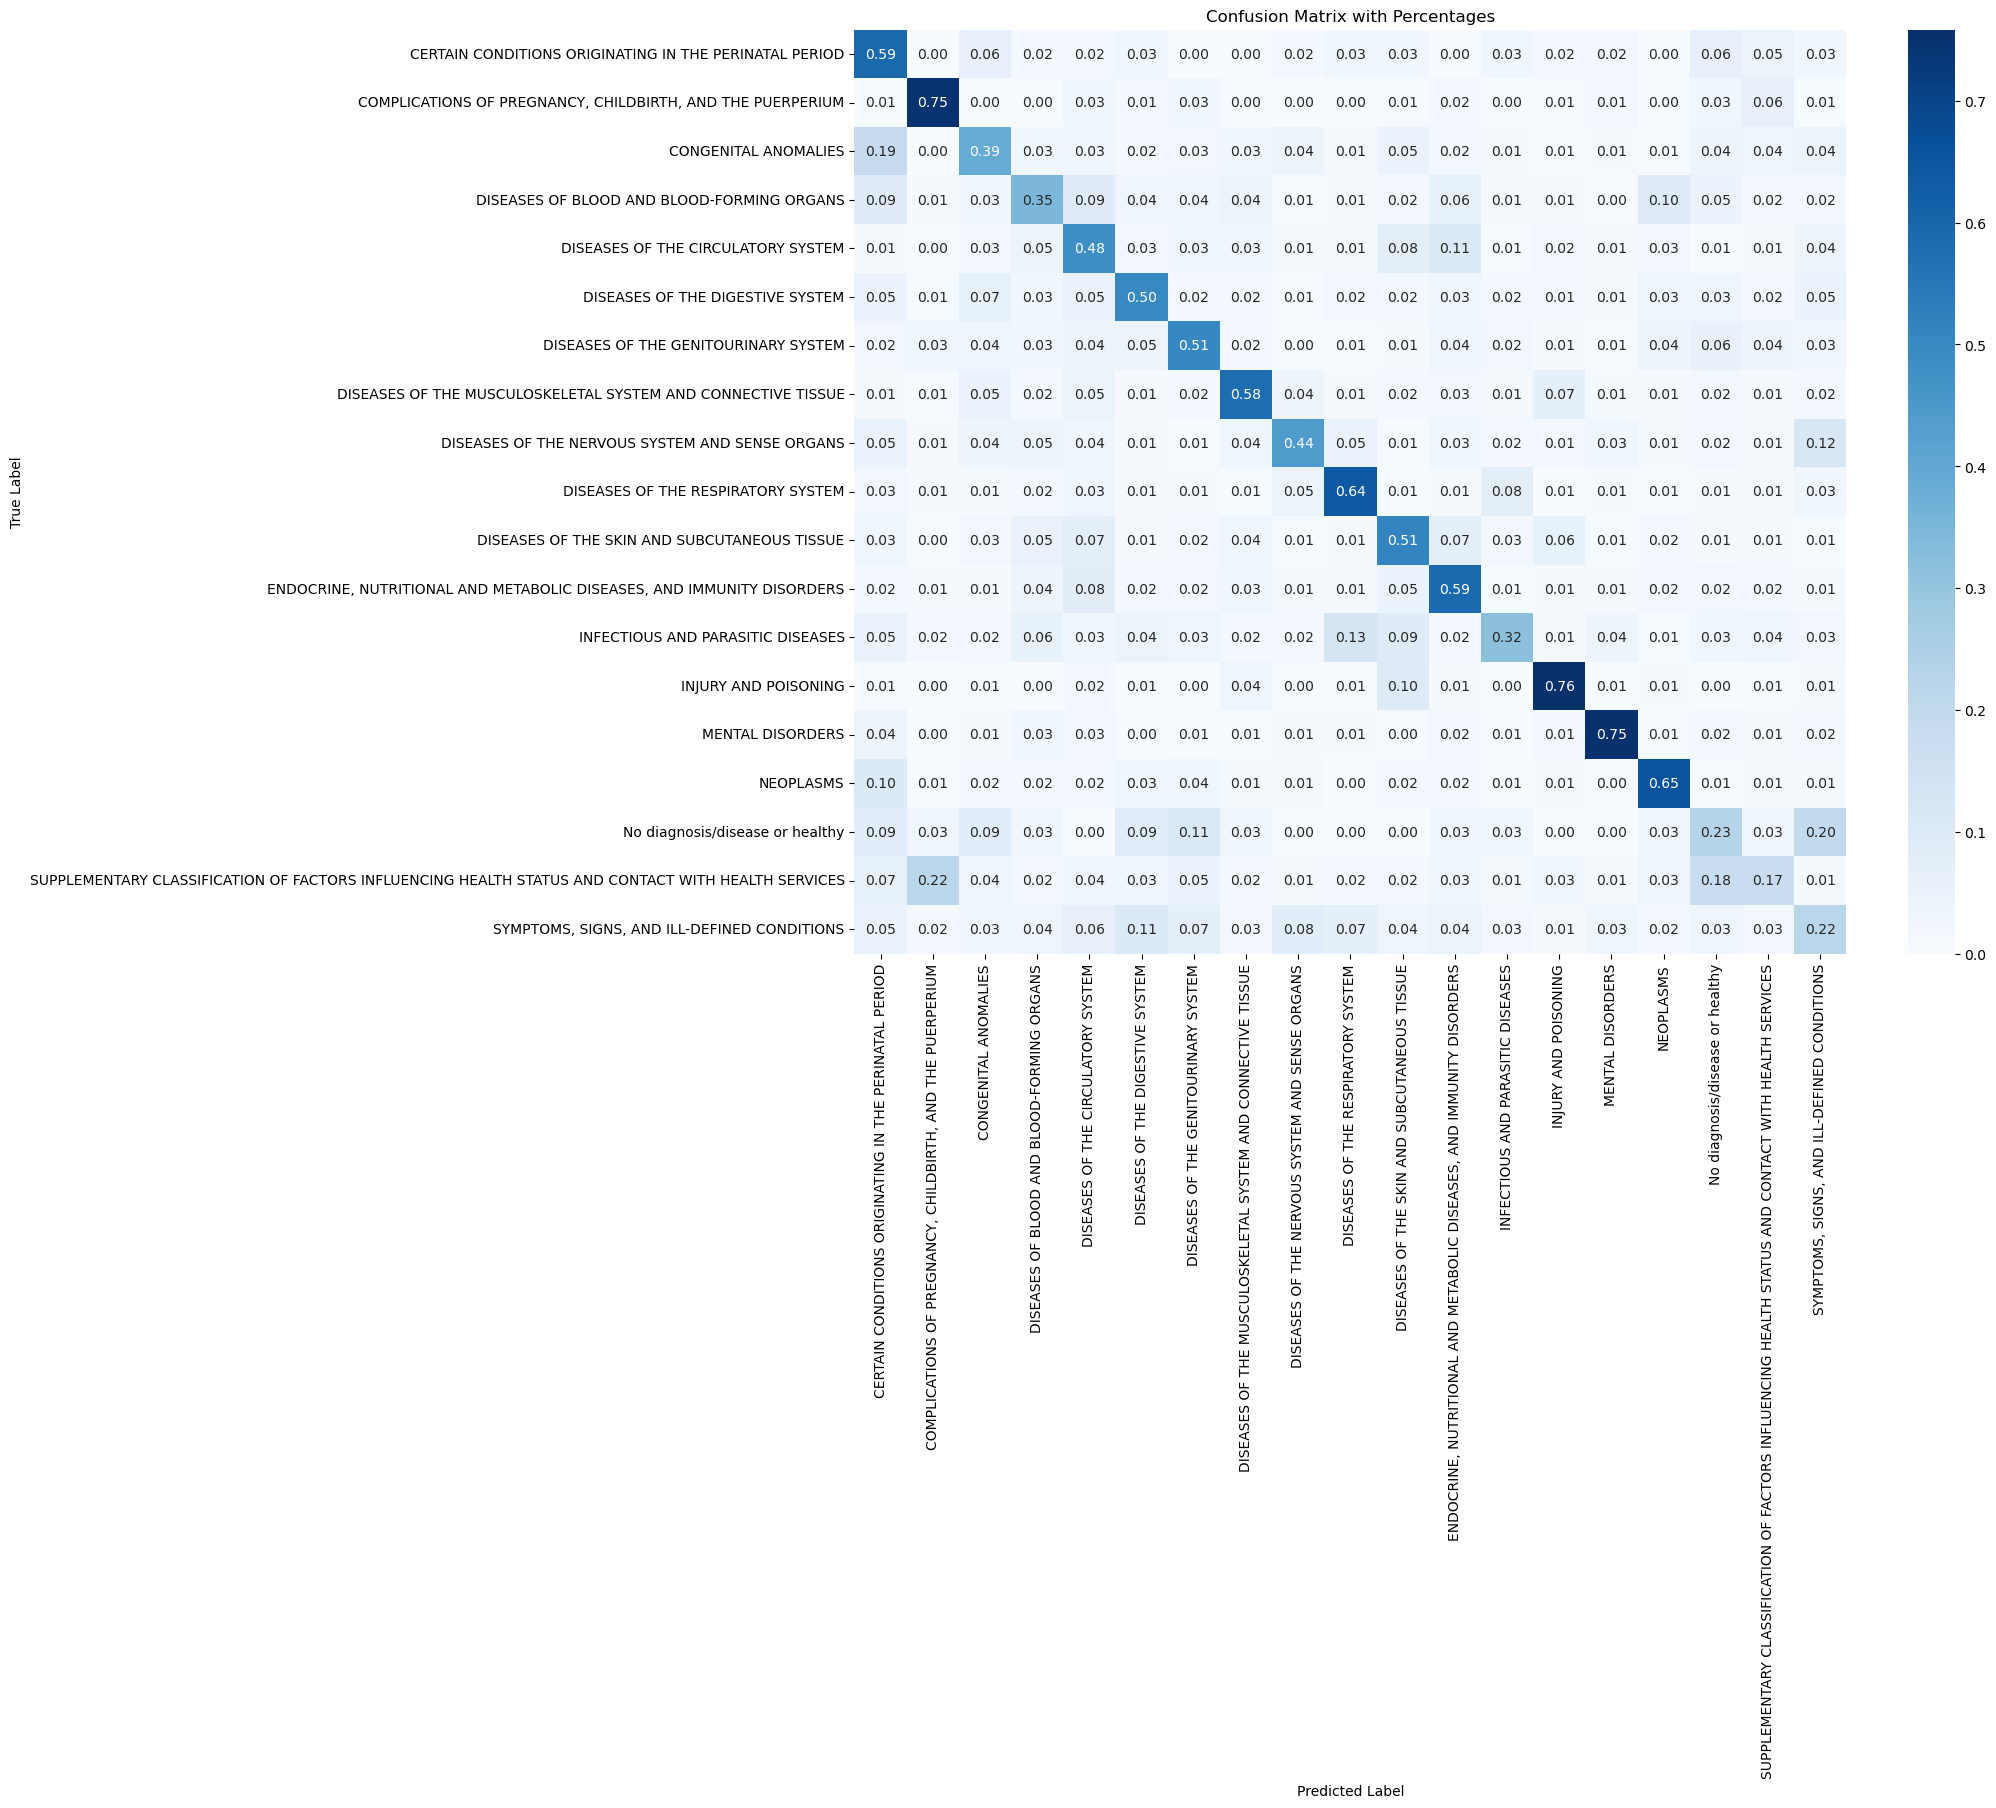

In [124]:
# Plot the confusion matrix with percentages
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test[y_test.notna()], y_pred[y_test.notna()])
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 12))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Percentages')
plt.show()

## 6 - Extract text features from each cluster

#### 6.1 - Aggregate text data by group

In [ ]:
for i, (k, v) in zip (range(len(variables)), variables.items()):
    if i < 5:
        print(k, v)

In [ ]:
for i, (k, v) in zip (range(len(variables)), variables.items()):
    if i >= 5 and i < 10:
        print(k, v)

In [ ]:
for i, (k, v) in zip (range(len(variables)), variables.items()):
    if i >= 10:
        print(k, v)

In [ ]:
train_df.USETOBAC.unique()

In [ ]:
train_df[variables['visitReason']].head()

In [ ]:
train_df[variables['vitalSigns']].value_counts()

In [ ]:
train_df[variables['physicianDiagnoses']].head()

In [ ]:
print(train_df.PRDIAG1.unique())
print()

train_df.DIAG1[train_df.PRDIAG1.str.contains('not probable') | (train_df.PRDIAG1 == 'No')].value_counts()

In [ ]:
train_df[variables['presentSymptomsStatus']].value_counts()

In [ ]:
# Load custom function to combine text features
import sys
sys.path.append('../src/features/')

from combine_textual import combine_features


# Define the list of textual features to combine
textual_features = [
    'AGE', 'SEX', 'USETOBAC', 
    'MAJOR', 'RFV1', 'RFV2', 'RFV3', 
    'BMI', 'TEMPF', 'BPSYS', 'BPDIAS',
    'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'NOCHRON', 'DMP',
    'DIAG1', 'DIAG2', 'DIAG3'
]

# Export the list of textual features
with open(os.path.join(file_path, 'textual_features.json'), 'w') as f:
    json.dump(textual_features, f)

# Combine the text features
train_df['CombinedText'] = train_df.apply(lambda x: combine_features(x, textual_features), axis=1)

train_df.CombinedText.head()

In [ ]:
train_df.CombinedText.notna().sum()

#### 6.2 - Preprocess text data

In [ ]:
import spacy
import re

In [ ]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text(row):
    row = re.sub(r'(\d+),(\d+)', r'\1\2', row)
    row = re.sub(r'(\d+)-(\d+)', r'\1_\2', row)
    doc = nlp(row)
    processed_text = ' '.join(token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct)
    row = re.sub(r'(\d+)_(\d+)', r'\1-\2', row)
    return processed_text

In [ ]:
train_df['ProcessedText'] = train_df['CombinedText'].apply(preprocess_text)

In [ ]:
train_df.ProcessedText.head()

In [ ]:
# Save the preprocessed DataFrame
processed_file_path = os.path.join('..', 'data', 'processed')
train_df.to_csv(os.path.join(processed_file_path, f'train_{clustering_model_name}.csv'), index=False)

#### 6.3 - Calculate term frequencies

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Method 1
# Calculate the TF-IDF for each cluster,
# taking the ProcessedText of each cluster as the documents,
# and the ProcessedText of the entire dataset as the corpus

#clustered_text = train_df.groupby('cluster')['ProcessedText'].apply(lambda row: ' '.join(row)).reset_index()

#vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000, min_df=5, max_df=0.7)
#tfidf_matrix = vectorizer.fit_transform(clustered_text['ProcessedText'])

#print(tfidf_matrix)

#tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
#tfidf_df

In [ ]:
# Method 2
# Calculate the TF-IDF of each row within each cluster
# Calculate the average TF-IDF for each cluster

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000, min_df=5, max_df=0.7)
tfidf_matrix = vectorizer.fit_transform(train_df['ProcessedText'])

# Calculate the average TF-IDF for each cluster
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
cluster_tfidf = pd.concat([train_df['cluster'], tfidf_df], axis=1).groupby('cluster').mean()

cluster_tfidf

In [ ]:
# Punish the weight of '\d+_year_old' by multiplying it by 0.5, using the regex pattern

#tfidf_df = tfidf_df.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)
#cluster_tfidf = cluster_tfidf.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)

#cluster_tfidf

#### 6.4 - Generate word clouds for each group

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Plot the word cloud for each cluster basd on the average TF-IDF
for i in range(n_clusters):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(cluster_tfidf.loc[i])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {i}')
    plt.show()

## 7 - Topic modeling

In [ ]:
import gensim
from gensim import corpora

random_seed = 42

In [ ]:
# Generate bigrams
def generate_bigrams(row):
    tokens = row.split()
    bigram_model = gensim.models.Phrases(tokens, min_count=5, threshold=100)
    tokens = [token for token in bigram_model[tokens]]
    return tokens


print(generate_bigrams(train_df['ProcessedText'].iloc[0]))
preprocessed_docs = train_df['ProcessedText'].apply(generate_bigrams)

In [ ]:
# Build dictionary and corpus
dictionary = corpora.Dictionary(preprocessed_docs)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

In [ ]:
# Train LDA model
n_topics = 10

lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=n_topics,
    random_state=random_seed,
    chunksize=100,
    passes=10,
)



### 7.1 - Visualize the topics

In [ ]:
import pyLDAvis.gensim_models
import pyLDAvis

pyLDAvis.enable_notebook()

In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

### 7.2 - Get the topic distribution for each cluster

In [ ]:
# Get the topic distribution for each document 
def get_avg_topic_distribution(cluster_data, topic_distribution, num_topics):
    cluster_topics = np.zeros((len(cluster_data.index), num_topics))

    # Update the distribution with the actual values
    for i, doc_index in enumerate(cluster_data.index.tolist()):
        for topic, prob in topic_distribution[doc_index]:
            cluster_topics[i, topic] = prob

    avg_topic_dist = np.mean(cluster_topics, axis=0)
    return avg_topic_dist


topic_distribution = lda_model.get_document_topics(corpus, minimum_probability=0.0)
clusters = train_df.groupby('cluster').ProcessedText

cluster_topics = []
for cluster, data in clusters:
    avg_topic_dist = get_avg_topic_distribution(data, topic_distribution, lda_model.num_topics)
    cluster_topics.append([avg_topic_dist.tolist()])

cluster_topics_df = pd.DataFrame(cluster_topics, columns=['avg_topic_distribution'])

cluster_topics_df

### 7.3 - Visualize the distribution of topics within each cluster

In [ ]:
import altair as alt

In [ ]:
# Reshape the dataframe to have a row for each cluster and topic
cluster_topics_heatmap_df = cluster_topics_df.avg_topic_distribution.apply(pd.Series).reset_index().rename(columns={'index': 'cluster'}).melt(id_vars='cluster', var_name='topic', value_name='probability')

heatmap = alt.Chart(cluster_topics_heatmap_df).mark_rect().encode(
    x='topic:O',
    y='cluster:O',
    color='probability:Q'
).properties(
    title='Average Topic Distribution for Each Cluster',
    width=400,
    height=400
)

heatmap